In [1]:
from __future__ import division
%matplotlib inline
import numpy as np
import scipy.io as sio
import itertools
from matplotlib import pyplot as plt
import meta_features as mf
from scipy import interp
from sklearn.metrics import classification_report, roc_curve,  confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.externals import joblib
from collections import Counter

## Load data

In [5]:
data = sio.loadmat('../data/num_data_aug.mat')['data']
# Remove not tagged instances (e.g., Enrico's low frequency gameplay)
# 0 is the code for not tagged data. 

print 'Lenght of dataset: {}'.format(data.shape)
invalid_mprimitives = [i for i,d in enumerate(data) if d[-1] == 0]
print 'Invalids: {}'.format(invalid_mprimitives)
print 

data = data[data[:,-1] != 0]
print 'Lenght of dataset (after invalid removal): {}'.format(data.shape)
print data

Lenght of dataset: (388, 7)
Invalids: [189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209]

Lenght of dataset (after invalid removal): (367, 7)
[[ 0.31612362  0.51076294  1.         ...,  1.19060919  3.42123432  1.        ]
 [ 0.23859909  0.30645777  1.         ...,  0.63196545  3.77933016  1.        ]
 [ 0.49870963  2.14520436  4.         ...,  6.29437589  2.68336024  3.        ]
 ..., 
 [ 0.49741322  3.27630447  6.         ...,  8.36395936  2.01679775  3.        ]
 [ 0.36464193  1.33099869  3.         ...,  3.3898593   2.84611253  2.        ]
 [ 0.57603441  2.45722835  4.         ...,  5.65549558  2.22981438  3.        ]]


In [6]:
X = data[:,:-3]  # Load X.
y = data[:,-1]   # Load y

#label remap
labels = {1: 'locally_moving', 2:'walk/dodging', 3:'running'}

In [7]:
res = joblib.load('matches.pkl') 
ci_prox = joblib.load('ci_proximity.pkl')
clf = joblib.load('classifier.pkl') 

In [8]:
proc_res = [(d['ci_means'],d['prox_means']) for i,d in enumerate(res) if i not in invalid_mprimitives]
assert len(data) == len(proc_res)

## Testing the activity formula

In [94]:
start = 38#366-28
end   = 47#366
interval = range(start,end+1,1)
print "Interval: {}".format(interval)
print len(interval)

X_test = X[start:end]
y_test = y[start:end]

Interval: [38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
10


In [95]:
n_classes = 3
omega = [1, 30, 60]
#assert np.sum(omega) == 1

Interval number: 38
Starts at: 0.0
Ends at: 0.827356321839
Prediction [[ 0.1  0.9  0. ]]
Energy: 0.20076740128
Activity_level: 5.44

Interval number: 39
Starts at: 1.13761494253
Ends at: 4.75729885057
Prediction [[ 0.  0.  1.]]
Energy: 0.425407799749
Activity_level: 25.52

Interval number: 40
Starts at: 5.27439655172
Ends at: 5.48123563218
Prediction [[ 1.  0.  0.]]
Energy: 0.061545207205
Activity_level: 0.06

Interval number: 41
Starts at: 7.03252873563
Ends at: 8.89408045977
Prediction [[ 0.  0.  1.]]
Energy: 0.651852433272
Activity_level: 39.11

Interval number: 42
Starts at: 9.20433908046
Ends at: 13.8582183908
Prediction [[ 0.  0.  1.]]
Energy: 0.364834251451
Activity_level: 21.89

Interval number: 43
Starts at: 14.5821551724
Ends at: 16.7539655172
Prediction [[ 0.  0.  1.]]
Energy: 0.44578884693
Activity_level: 26.75

Interval number: 44
Starts at: 18.7189367816
Ends at: 19.1326149425
Prediction [[ 1.  0.  0.]]
Energy: 0.0506992313728
Activity_level: 0.05

Interval number: 45
Sta

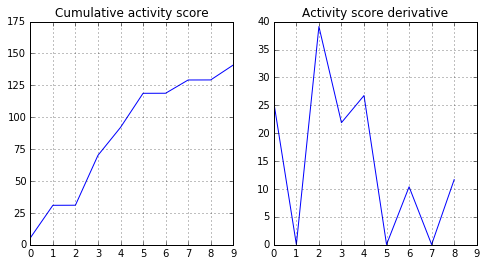

In [96]:
import matplotlib.patches as patches
preds = []
act_level = []
sums = []
begins = []
ends = []
for i in interval:
    print 'Interval number: {}'.format(i)
    print 'Starts at: {}'.format(res[i]['dt_samples'][0])
    begins.append(res[i]['dt_samples'][0])
    print 'Ends at: {}'.format(res[i]['dt_samples'][-1])
    ends.append(res[i]['dt_samples'][-1])
    pred = clf.predict_proba(X[i].reshape(1,-1))
    print 'Prediction {}'.format(pred)
    preds.append(pred)
    summation = 0
    epsilon = mf.energy(res[i]['act'])
    print 'Energy: {}'.format(epsilon)
    for j in range(n_classes):
        summation += omega[j]*pred[0][j]*epsilon
    if len(sums) == 0:
        sums.append(summation)
    else:
        sums.append(sums[-1]+summation)
    act_level.append(summation)
    print 'Activity_level: {:.2f}'.format(summation)
    print

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(121)
ax.plot(sums)
ax.set_yticks(range(0,200,25))
ax.set_xticks(range(len(sums)))
ax.grid()
ax.set_title('Cumulative activity score')

ax2 = fig.add_subplot(122)
dev = np.diff(sums)
ax2.plot(dev)
ax2.set_xticks(range(len(sums)))
ax2.grid()
ax2.set_title('Activity score derivative')
plt.show()


## Fuzzy

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


iteration: 0
iteration: 100
iteration: 200
iteration: 300
DONE!


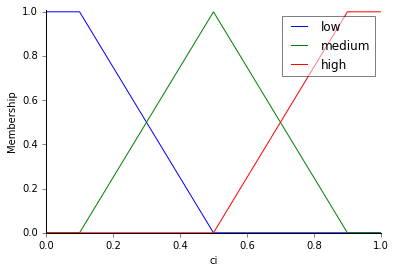

In [101]:
import numpy as np
import  as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
ci = ctrl.Antecedent(np.arange(0, 1.1, .1), 'ci')
proximity = ctrl.Antecedent(np.arange(0, 1.1, .1), 'proximity')
interaction_level = ctrl.Consequent(np.arange(0, 1.1, .1), 'interaction_level')

# membership function population
ci['low'] = fuzz.trapmf(ci.universe, [0,0,.1,.5])
ci['medium'] = fuzz.trimf(ci.universe, [.1, .5, .9])
ci['high'] = fuzz.trapmf(ci.universe, [.5, .9, 1, 1])
proximity['low'] = fuzz.trapmf(proximity.universe, [0,0,.1,.5])
proximity['medium'] = fuzz.trimf(proximity.universe, [.1, .5, .9])
proximity['high'] = fuzz.trapmf(proximity.universe, [.5, .9, 1, 1])

ci.view()

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
interaction_level['low'] = fuzz.trapmf(interaction_level.universe, [0,0,0,0])
interaction_level['medium'] = fuzz.trapmf(interaction_level.universe, [.5, .5, .5,.5])
interaction_level['high'] = fuzz.trimf(interaction_level.universe, [1, 1, 1])

rule1 = ctrl.Rule(ci['low'] & proximity['low'], interaction_level['low'])
rule2 = ctrl.Rule(ci['medium'] & proximity['medium'], interaction_level['medium'])
rule3 = ctrl.Rule(ci['high'] & proximity['high'], interaction_level['high'])
rule4 = ctrl.Rule(ci['low'] & proximity['high'], interaction_level['medium'])
rule5 = ctrl.Rule(ci['high'] & proximity['low'], interaction_level['medium'])
rule6 = ctrl.Rule(ci['low'] & proximity['medium'], interaction_level['low'])
rule7 = ctrl.Rule(ci['medium'] & proximity['low'], interaction_level['low'])
rule8 = ctrl.Rule(ci['medium'] & proximity['high'], interaction_level['high'])
rule9 = ctrl.Rule(ci['high'] & proximity['medium'], interaction_level['high'])


interaction_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
interaction_out = ctrl.ControlSystemSimulation(interaction_ctrl)

# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
kappa = []
fuzzy_out = []

for ind,i in enumerate(proc_res):
    if ind % 100 == 0:
        print 'iteration: {}'.format(ind)
    
    c = None
    p = None

    if np.isnan(i[0]):
        c = 0
    else:
        c = i[0]
    
    if np.isnan(i[1]):
        p = 0
    else:
        p = i[1]
    
    #print 'Ci={}, prox= {}'.format(c,p)
    interaction_out.input['ci'] = c
    interaction_out.input['proximity'] = p


    
    # Crunch the numbers
    interaction_out.compute()


    result = interaction_out.output['interaction_level']
    fuzzy_out.append(result)
    
    #print 'interaction_level: {}'.format(result)
    
    k= None
    if result < 0.3:
        k = 1
    elif (result >= 0.3) and (result < 0.6):
        k = 2
    elif (result >= 0.6) and (result < 1):
        k = 3
    
    #print 'gain factor: {}'.format(k)
    kappa.append(k)
    
    #interaction_level.view(sim=interaction_out)
print 'DONE!'


In [98]:
print len(fuzzy_output)
print len(proc_res)

367
367


## Engagement computation

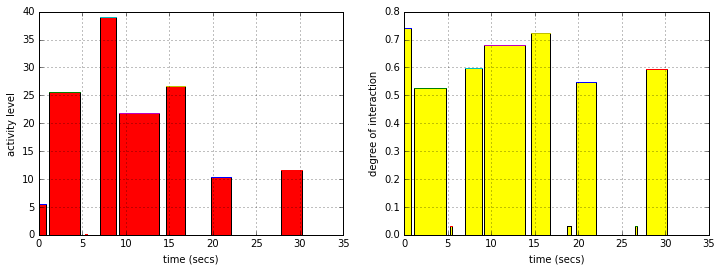

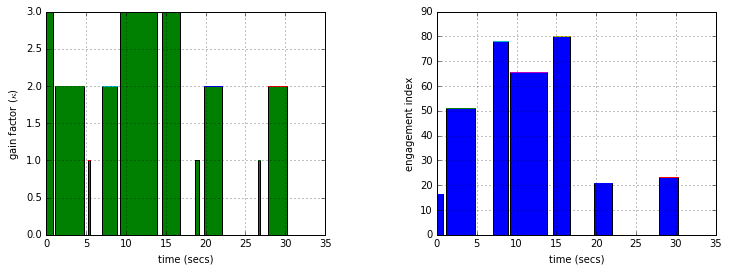

In [100]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(121)

for i, (b,e) in enumerate(zip(begins,ends)):
    xs = np.linspace(b,e,100)
    ys = np.ones_like(xs) * act_level[i]
    
    p = patches.Rectangle(
        (xs[0], 0), e-b, act_level[i], facecolor="red", #fill=False,
        linewidth=None,      # Default
    )
    ax.plot(xs,ys)
    ax.add_patch(p)

plt.xlabel('time (secs)')
plt.ylabel('activity level')
plt.grid()
plt.draw()

ax1 = fig.add_subplot(122)

for i, (b,e) in enumerate(zip(begins,ends)):
    xs = np.linspace(b,e,100)
    ys = np.ones_like(xs) * fuzzy_out[start:end+1][i]
    
    p = patches.Rectangle(
        (xs[0], 0), e-b, fuzzy_out[start:end+1][i], facecolor="yellow", #fill=False,
        linewidth=None,      # Default
    )
    ax1.plot(xs,ys)
    ax1.add_patch(p)

plt.xlabel('time (secs)')
plt.ylabel('degree of interaction')
plt.grid()
plt.draw()

fig = plt.figure(figsize=(12,4))

ax2 = fig.add_subplot(121)
inter_levs = kappa[start:end+1]

for i, (b,e) in enumerate(zip(begins,ends)):
    
    xs = np.linspace(b,e,100)
    ys = np.ones_like(xs) * inter_levs[i]
    
    p = patches.Rectangle(
        (xs[0], 0), e-b, inter_levs[i], facecolor="green", #fill=False,
        linewidth=None,      # Default
    )
    ax2.plot(xs,ys)
    ax2.add_patch(p)
plt.xlabel('time (secs)')
plt.ylabel('gain factor ($\kappa$)')
plt.grid()
plt.draw()

ax3 = fig.add_subplot(122)

for i, (b,e) in enumerate(zip(begins,ends)):
    engagement = act_level[i] * inter_levs[i]
    
    xs = np.linspace(b,e,100)
    ys = np.ones_like(xs) * engagement
    
    p = patches.Rectangle(
        (xs[0], 0), e-b, engagement, facecolor="blue", #fill=False,
        linewidth=None,      # Default
    )
    ax3.plot(xs,ys)
    ax3.add_patch(p)
plt.xlabel('time (secs)')
plt.ylabel('engagement index')
plt.grid()
fig.subplots_adjust(hspace=0.5, wspace= 0.4)
plt.show()